## Import Libraries

In [ ]:
import numpy as np        # for manipulating arrays
import pandas as pd      # to read data points as data frame
import math           # for performing math operations
from matplotlib import image  # for reading image as array
import matplotlib.pyplot as plt  # for plotting image
%matplotlib inline

## Reading Images and SIFT correspondences 

In [ ]:
img1="/content/drive/MyDrive/0_Image_Labs/Lab3/img1.png"        # Provide Necessary Paths to image
img2="/content/drive/MyDrive/0_Image_Labs/Lab3/img2.png"
img3="/content/drive/MyDrive/0_Image_Labs/Lab3/img3.png"

img1_array=image.imread(img1)     # img1 array
img2_array=image.imread(img2)     # img2 array
img3_array=image.imread(img3)     # img3 array


# Give necessary paths to Excel files which contains pt. correspondences between 2 images
img12_1=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/12_1.xlsx',header=None))  #Image1 Pts. as source: Correspondeces between img1 and img2
img12_2=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/12_2.xlsx',header=None))  #Image2 Pts. as source: Correspondeces between img1 and img2
img23_2=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/23_2.xlsx',header=None))  #Image2 Pts. as source: Correspondeces between img2 and img3
img23_3=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/23_3.xlsx',header=None))  #Image3 Pts. as source: Correspondeces between img2 and img3



print(f'Size of Image1: {img1_array.shape}')
print(f'Size of Image2: {img2_array.shape}')
print(f'Size of Image3: {img3_array.shape}')

print(f'Image1: Pt. Correspondeces between img1 and img2 : {img12_1.shape}')
print(f'Image2: Pt. Correspondeces between img1 and img2 : {img12_2.shape}')
print(f'Image2: Pt. Correspondeces between img2 and img3 : {img23_2.shape}')
print(f'Image3: Pt. Correspondeces between img2 and img3 : {img23_3.shape}')

Size of Image1: (360, 640)
Size of Image2: (360, 640)
Size of Image3: (360, 640)
Image1: Pt. Correspondeces between img1 and img2 : (358, 2)
Image2: Pt. Correspondeces between img1 and img2 : (358, 2)
Image2: Pt. Correspondeces between img2 and img3 : (371, 2)
Image3: Pt. Correspondeces between img2 and img3 : (371, 2)


## 0.Utility Functions

In [ ]:
def display_image(image1, transformed_image,image2,title1, title2,title3):     # Plotting Multiple Images 
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,24), constrained_layout=True)   # plotting 3 images side by side
    ax1.title.set_text(title1)
    ax2.title.set_text(title2)   
    ax3.title.set_text(title3)  
    ax1.imshow(image1, cmap=plt.get_cmap('gray'))
    ax2.imshow(transformed_image, cmap=plt.get_cmap('gray'))
    ax3.imshow(image2, cmap=plt.get_cmap('gray'))

def plot(img):  # Plotting single image
    plt.figure(figsize=(14,18))
    plt.imshow(img, cmap=plt.get_cmap('gray'),interpolation='none') 
     
def valid(arr,xs,ys):                                            # Function to return Intensity=0 , for those coordinates which we dont have information of (out of size coordinates)
    if xs>=0 and ys>=0 and xs<len(arr) and ys<len(arr[0]): return arr[xs,ys]  # if point present in image return its intesnity
    else: return 0     # if pt. is not present return 0 intensity

def check_in(array,x,y):#To find whether a given point is in the image 
    if x>=0 and y>=0 and x<array.shape[0] and y<array.shape[1]: return 1          # if point inside image return 1
    else: return 0        # if point outside return 0

def Bilinear_Interpolate(arr,xs,ys):                             # Function for performing Bilinear Interpolation for pt. (xs,ys)
    Xs,Ys=math.floor(xs),math.floor(ys)
    a,b=xs-Xs,ys-Ys
    W1,W2,W3,W4=(1-a)*(1-b), (1-a)*b, a*(1-b), a*b    # weights
    return (W1*valid(arr,Xs,Ys)  +  W2*valid(arr,Xs,Ys+1)  +  W3*valid(arr,Xs+1,Ys)  +  W4*valid(arr,Xs+1,Ys+1), check_in(arr,xs,ys))  #returning 1. weighted avg of intensities of neighbouring pixel coordinates 2. (0,1)-depending on pt. present in image or not


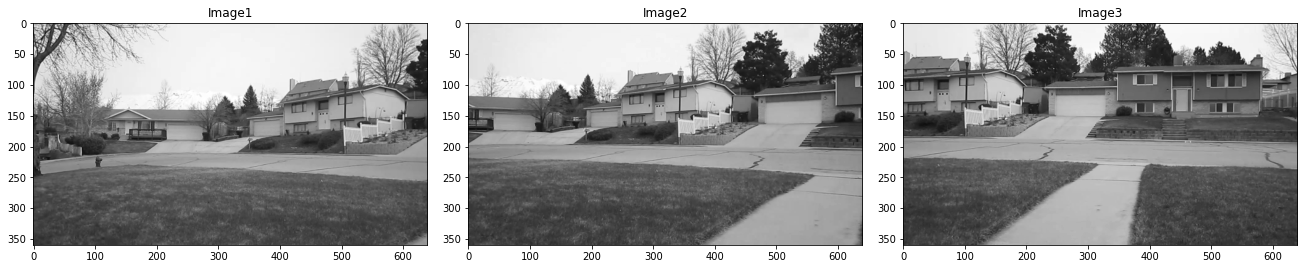

In [ ]:
display_image(img1_array,img2_array,img3_array,'Image1','Image2','Image3')     # displaying images

# 1. RANSAC

### 1.1 Computing H Function:

###  * Formulation for H matrix Calculation:

we know: 
$$ 
\begin{bmatrix} \lambda x^{'} \\ \lambda y^{'} \\ \lambda  \end{bmatrix} =  H \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}         -----eqn1
$$


   
   So corresponding  H matrix:
$$
H= \begin{bmatrix} h_{1} & h_{2} &  h_{3} \\ h_{4} & h_{5} & h_{6} \\ h_{7} & h_{8} & h_{9}
\end{bmatrix}  -----eqn2
$$


Simplifying above eqns 1,2 we get:
$$
\begin{bmatrix}   -x & -y & -1 & 0 & 0 & 0 & xx^{'} & yx^{'} & x^{'} \\ 0 & 0 & 0 & -x & -y & -1 & xy^{'} & yy^{'} & y^{'} \end{bmatrix} \begin{bmatrix} h_{1} \\ h_{2} \\ h_{3} \\ h_{4} \\ h_{5} \\ h_{6} \\ h_{7} \\ h_{8} \\h_{9} \end{bmatrix}=\bar 0
$$


$$ A= \begin{bmatrix}   -x & -y & -1 & 0 & 0 & 0 & xx^{'} & yx^{'} & x^{'} \\ 0 & 0 & -0 & -x & -y & -1 & xy^{'} & yy^{'} & y^{'} \end{bmatrix}  $$
and 
$$ \bar h=\begin{bmatrix} h_{1} \\ h_{2} \\ h_{3} \\ h_{4} \\ h_{5} \\ h_{6} \\ h_{7} \\ h_{8} \\h_{9} \end{bmatrix}$$

So we need to find:
$$   A\bar h = \bar 0  $$

$\bar h$ = Nullspace of A matrix 

and using $\bar h$ we can easily find Homography matrix  $H$ 

In [ ]:
import scipy
from scipy.linalg import null_space

def compute_H(source,target):
    """
    Arg: 
    Input=source image pts. and its corresonding target image pts
         
    Output=H (homography)matrix
    """          
    A=[]
    for i in range(len(source)):
        temp=np.zeros((2,9))
        temp[0,0],temp[0,1],temp[0,2],temp[0,6],temp[0,7],temp[0,8]=-source[i][0],-source[i][1],-1,source[i][0]*target[i][0],source[i][1]*target[i][0],target[i][0]
        temp[1,3],temp[1,4],temp[1,5],temp[1,6],temp[1,7],temp[1,8]=-source[i][0],-source[i][1],-1,source[i][0]*target[i][1],source[i][1]*target[i][1],target[i][1]
        A.append(temp)
    A=np.array(A).reshape(-1,9)    
    h=np.array(null_space(A))
    H=h.reshape(3,3)
    return H

## 1.2 RANSAC Algorithm to find optimum H

#### Parameters:  

1. For consesus_count,  Here I have kept factor of 0.9 
2. For error Threshold (in pixels), Here I have kept 5 
3. Iteration limit= 100

####  Input/Output: 

1. Input to RANSAC Function is data1, data2 pt. correspondences found through SIFT Matlab code
2. Output= Optimised H matrix 

In [ ]:
def RANSAC(data1,data2):               # img1 = H21.img2   and img3 = H23.img2   
    """
    Arg: 
    Input= data1 pts. and its corresonding data2 pts. Found from SIFT Matlab code
         
    Output= Optimised H (homography)matrix
    """    
    iteration=0
    consensus_count=0   #initialisaed 0 first
    while consensus_count<0.9*len(data1):     # Hyper parameter= factor(0.9)---Change accordingly for best results
        
        random_idx=np.random.choice(data1.shape[0], 4, replace=False)    # generate 4 random indexes
        source_pts,target_pts=data1[random_idx],data2[random_idx]    # 4 random pts selected based on random indexs generated above
        rest_source_pts,rest_target_pts=[],[]
        for i in range(len(data1)):
            if i not in random_idx:
                rest_source_pts.append(data1[i])
                rest_target_pts.append(data2[i])
        rest_source_pts=np.array(rest_source_pts)   # segregating choosen points for Homography with rest points to run homography on later
        rest_target_pts=np.array(rest_target_pts)  

        H=compute_H(source_pts,target_pts)   # computing H matrix using 4 random point correspondences

        consensus_count=0
        for i in range(len(rest_source_pts)):
            (x,y,c)= H @  np.array(list(rest_source_pts[i])+[1])
            x_new,y_new=x/c,y/c    # finding new_pt using Homography
            if np.sqrt((rest_target_pts[i][0]-x_new)**2+(rest_target_pts[i][1]-y_new)**2)<5:   # finding euclidean distance between new_pt. and original point to check the error within threshold or not
                consensus_count+=1
        iteration+=1
        if iteration==100:
            break          
    print(f"iteration={iteration}")
    print(f"consensus_count={consensus_count}")
    return H           

H21=RANSAC(img12_2,img12_1)   # H21 matrix for image 2->1
H23=RANSAC(img23_2,img23_3)   # H23 matrix for image 2->3

iteration=2
consensus_count=353
iteration=7
consensus_count=367


### Usually Observed that RANSAC Algorithm converges withing 5-10 Iterations

## 1.3 Image mosaicing-----Stitching the 3 images

In [ ]:
def blend(v1,v2,v3):   # 0th index=intensity value, 1st index of v=(0 or 1) depending on pixel present in image or not
    Sum= v1[1]+v2[1]+v3[1]
    if Sum != 0:   # if point lies in atleast 1 of the image   
        return (v1[0]*v1[1]+v2[0]*v2[1]+v3[0]*v3[1])/Sum       # return weighted average
    else:    
        return 0    #If point doesn't lie in any image, return 0

def Stitch(H21,H23,img1_array,img2_array,img3_array):   # reference taken from pseudo code given in Problem statement
    target_array = np.zeros((600,1500))
    (OffsetRow,OffsetCol)=(100,200)
    for xt in range(len(target_array)):
        for yt in range(len(target_array[0])):
                (xs2,ys2) = (xt-OffsetRow,yt-OffsetCol)
                (x,y,c) = np.matmul(H21,[xs2,ys2,1]) 
                (xs1,ys1) = (x/c,y/c)    # corresponding coordinate in image1
                (x,y,c) = np.matmul(H23,[xs2,ys2,1]) 
                (xs3,ys3) = (x/c,y/c)    # corresponding coordinate in image3
                                                             # applying bilinear interpolation
                v1 = Bilinear_Interpolate(img1_array,xs1,ys1)
                v2 = Bilinear_Interpolate(img2_array,xs2,ys2)
                v3 = Bilinear_Interpolate(img3_array,xs3,ys3)
                
                target_array[xt,yt]=blend(v1,v2,v3)    #blending the 3 pixels intensity in 3 diff images to give avg Intensity for target image pixel
    return target_array             

### For making stitch more finer at the borders I am using weighted avgs inside blend function

$$ 
I= (w_{1} I_{1}  +w_{2}I_{2}+w_{3}I_{3})/(w_{1}+w_{2}+w_{3})
$$
Where $I_{1}, I_{2}, I_{3}$ is found through Bilinear interpolation between img2->img1 and img2->img3 and $w_{1} , w_{2}, w_{3}$ are either 0 or 1 depending upon if the point is present in image or not

## Final Stitched Image 

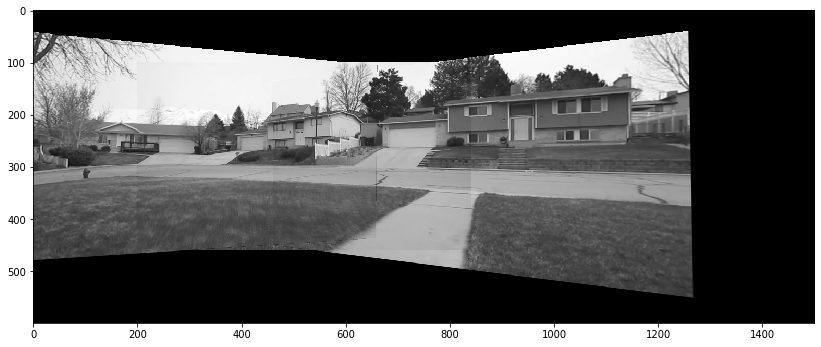

In [ ]:
stitched_img=Stitch(H21,H23,img1_array,img2_array,img3_array)    # stitched_image array
plot(stitched_img)    # plotting the stitched image

## Observation:
1. Images are stitched decently
2. Slight border of images can be seen in very faint way
3. Parallax effect is not seen: It can be due to the reason that buildings are too far to be assumed as Fronto parallel case or 2nd reason can be that the images are captured in pure rotation form so there no sense of translation hence depth doesnt matters in Homography Matrix even  3D scene too.

# 2. Running Code on My own clicked Images of SAC(Insti)

In [ ]:
from PIL import Image
sac1="/content/drive/MyDrive/0_Image_Labs/Lab3/My_images/s1.jpg"   # give path to RGB sac images
sac2="/content/drive/MyDrive/0_Image_Labs/Lab3/My_images/s2.jpg"
sac3="/content/drive/MyDrive/0_Image_Labs/Lab3/My_images/s3.jpg"


def resize_grayscale(path,size):   # resizing and converting RGB image to grayscale 
    img = Image.open(path)
    print(f"Original size={img.size}")
    img = img.resize(size, Image.ANTIALIAS)
    img=np.dot(np.array(img)[...,:3], [0.2989, 0.5870, 0.1140])
    print(f"Resized into {img.shape}")
    return img

sac1_array=resize_grayscale(sac1,(640,360))    # resized Image arrays
sac2_array=resize_grayscale(sac2,(640,360))
sac3_array=resize_grayscale(sac3,(640,360))

#image.imsave('sac1.png', sac1_array, cmap=plt.get_cmap('gray'))     #to save resized image into .png format  to RUN SIFT CODE to generate correspondences
#image.imsave('sac2.png', sac2_array, cmap=plt.get_cmap('gray'))
#image.imsave('sac3.png', sac3_array, cmap=plt.get_cmap('gray'))

Original size=(4624, 3106)
Resized into (360, 640)
Original size=(4624, 3102)
Resized into (360, 640)
Original size=(4624, 3125)
Resized into (360, 640)


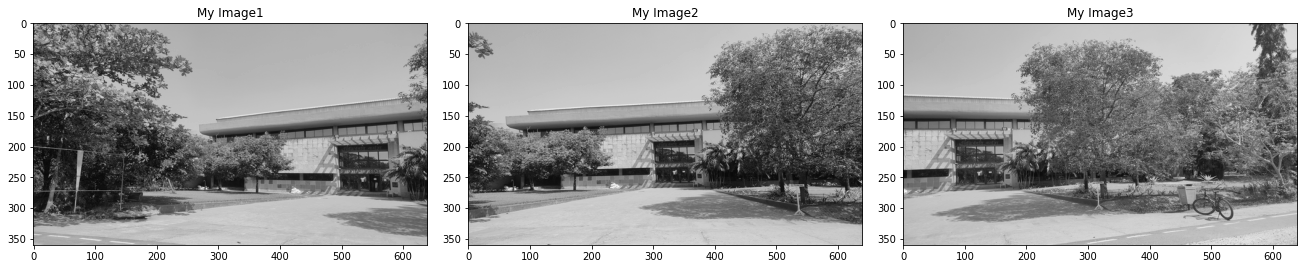

In [ ]:
display_image(sac1_array,sac2_array,sac3_array,'My Image1','My Image2','My Image3')

In [ ]:
# Reading pt. Correspondeces found using running SIFT Code on above images and saved in excel files

# Give necessary paths to Excel files which contains pt. correspondences between 2 images
sac12_1=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/My_images/sac12_1.xlsx',header=None))  #Image1 Pts. as source: Correspondeces between img1 and img2
sac12_2=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/My_images/sac12_2.xlsx',header=None))  #Image2 Pts. as source: Correspondeces between img1 and img2
sac23_2=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/My_images/sac23_2.xlsx',header=None))  #Image2 Pts. as source: Correspondeces between img2 and img3
sac23_3=np.array(pd.read_excel('/content/drive/MyDrive/0_Image_Labs/Lab3/My_images/sac23_3.xlsx',header=None))  #Image3 Pts. as source: Correspondeces between img2 and img3
print(f'Image1: Pt. Correspondeces between img1 and img2 : {sac12_1.shape}')
print(f'Image2: Pt. Correspondeces between img1 and img2 : {sac12_2.shape}')
print(f'Image2: Pt. Correspondeces between img2 and img3 : {sac23_2.shape}')
print(f'Image3: Pt. Correspondeces between img2 and img3 : {sac23_3.shape}')

H21_=RANSAC(sac12_2,sac12_1)
H23_=RANSAC(sac23_2,sac23_3)

Image1: Pt. Correspondeces between img1 and img2 : (359, 2)
Image2: Pt. Correspondeces between img1 and img2 : (359, 2)
Image2: Pt. Correspondeces between img2 and img3 : (321, 2)
Image3: Pt. Correspondeces between img2 and img3 : (321, 2)
iteration=4
consensus_count=338
iteration=3
consensus_count=313


## Final Stitched Image of SAC (Self-Clicked)

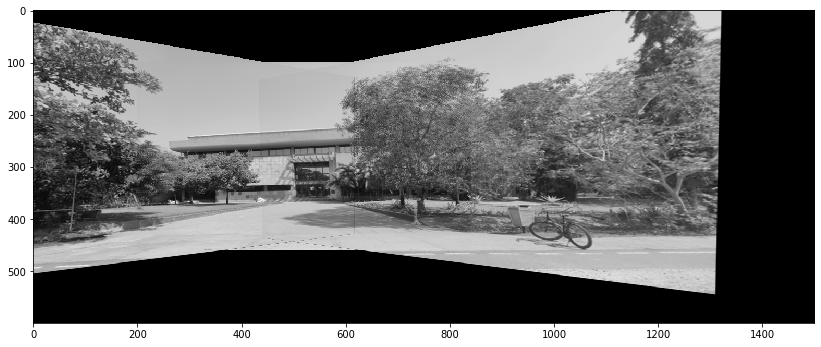

In [ ]:
stitched_img=Stitch(H21_,H23_,sac1_array,sac2_array,sac3_array)
plot(stitched_img)

### Observation:
1. Images of SAC are stitched well, Decent amount of overlapping regions might have helped for better stitching
2. Theres slight blur near leaves, Tree leaves might have caused some problem for SIFT to extract correspondence properly in that region.